# Introduction to EphysInterface

**EphysInterface is a tool for quickly plotting data while recording. This notebook explains how to set it up and use it.**

When recording electrophysiology data, it is helpful to be able to immediatly plot the results of a recording after collecting the data. `EphysInterface` is a tool for plotting the results of a recording, aligning responses with timestamps of events presented during the session, and performing quick spike-sorting to look at responses of individual clusters. This tool was created for several reasons: 

1. We often perform recordings where we want to find neurons that respond to a test stimulus (like a burst of noise) before recording a long session (like a frequency-intensity tuning curve). 
1. For some experiments, we need to find neurons that are responsive to multiple stimuli (like sound-responsive neurons that also respond to pulses of laser light). Without a tool for quickly looking at the responses of individual clusters, it is easy to record from a sound- and laser-responsive site for a long time and then find out later that different clusters at the site responded to the sound and the laser. This can be a huge waste of time and is very disappointing. 
1. Some experiments require the experimenter to determine some property of the site, or of the individual clusters, so that the appropriate stimuli can be presented during a recording. For instance, we may need to determine the best frequency of a site so that narrow-band noise centered at the preferred frequency can be presented. 

For these reasons, and probably others that I am not remembering, we built the `ephysinterface` module. It supplies the `EphysInterface` class, an instance of which has access to all the data being recorded (via an Inforec file, see "Introduction to Celldatabase") and has methods for aligning, clustering, and plotting the data in useful ways. It is our hope that `EphysInterface` will be useful for a wide variety of experiments, and that it is easily extensible to future needs. 

In [1]:
# This block sets up the example code that will be used in this notebook. 
# TODO: Where to store the example data? For now just a folder you have to get from jarahub:/data

from jaratoolbox import settings
reload(settings)
from matplotlib import pyplot as plt

settings.EPHYS_PATH = "/home/nick/data/testdata/ephys"
settings.BEHAVIOR_PATH = "/home/nick/data/testdata/behavior"

## Getting started on the day of the experiment

EphysInterface objects are initialized by passing an Inforec file. This file defines the list of experiments, sites, and sessions that have been recorded for an animal, and will provide the EphysInterface object with all the information it needs to load ephys and behavior files for any session. If you have never worked with inforec files, read the **Introduction to Celldatabase** notebook. You will write the inforec file as you conduct the experiment. To be able to load data, EphysInterface needs to have access to the inforec file. 

We will be using a test inforec file with a few sessions from the animal pinp015. These sessions contain a cell with a cool laser and AM response: 'pinp015_2017-02-15_2902.0_TT8c4'

---
### Inforec file contents
<pre>
from jaratoolbox import celldatabase

subject = 'pinp015'
experiments = []

exp = celldatabase.Experiment(subject,
                               '2017-02-15',
                               brainarea='rightThal',
                               info=['medialDiD'])
experiments.append(exp)

exp.add_site(2902, tetrodes=range(1, 9))
exp.add_session('12-51-41', None, 'laserpulse', 'am_tuning_curve') #strong laser response
exp.add_session('13-21-56', 'b', 'am', 'am_tuning_curve')
exp.maxDepth = 0
</pre>
---

We can see that the inforec file contains one experiment (**2017-02-15**), one site recorded at **2902um**, and two sessions (one laser pulse session and one AM session). 

## Initializing an EphysInterface object

The module `jaratoolbox.ephysinterface` provides the class `EphysInterface`. We will make an instance of this class, giving it the path to the inforec file for the animal we are recording from. 

In [3]:
# This is the first thing you need to type into the terminal you will use for EphysInterface while recording.

from jaratoolbox import ephysinterface
ei = ephysinterface.EphysInterface('/home/nick/data/testdata/test_pinp015_inforec.py')

## Writing the inforec file on a different computer

We use two computers for collecting ephys data in the Jaramillo lab. One computer is responsible for running the Taskontrol behavior system, which is used to present stimuli during the recording. The other computer runs the OpenEphys software for collecting the ephys data. We usually run EphysInterface on the computer that is collecting the ephys data, because the data is large and we don't want to rely on accessing it via the network. However, we usually write the Inforec file on the behvior computer. There are a few reasons for this: 

1. Ergonomics: The behavior monitor is comfortably at eye level (for the short-ish people in the Jara lab) while the ephys monitor is above eye level. It hurts the neck to be looking up at the ephys monitor for too long. 
1. CPU/mem usage: We want to limit the programs that are running on the ephys computer so that we don't have any issues with data collection because OpenEphys couldn't get the CPU time it needed or something. So we generally don't use web browsers or editors on that computer. 

However, the EphysInterface instance on the ephys computer needs access to the inforec file on the behavior computer. So, we usually use `sshfs` to mount the folder containing the inforec file on the ephys computer. The command to mount the remote directory will be something like this: 

`sshfs -o idmap=user jarauser@<jararig-ip-addr>:/path/to/inforec/folder /path/on/ephys/comp/`

You can then just supply the path to the mounted file when initializing the ephysinterface object. 


## Plotting event-locked spike rasters for a session
The most common thing you will need to do during an experiment is to plot rasters of spike times aligned to the times of events (auditory stimuli, laser pulses, etc.) that occurred during the session. Often, the first thing to do after recording a session is to plot an event-locked raster for each tetrode. 

### The `plot_array_raster()` method
This method probably gets the most use during normal recording sessions. The only required argument is which session you want to plot. The default behavior is to search within the most recent site of the most recent experiment for this session, although you can specify the site and the experiment as well. 

In [12]:
help(ei.plot_array_raster)

Help on method plot_array_raster in module jaratoolbox.ephysinterface:

plot_array_raster(self, session, experiment=-1, site=-1, tetrodes=None, replace=0, sortArray='currentFreq', timeRange=[-0.5, 1], ms=4, electrodeName='Tetrode') method of jaratoolbox.ephysinterface.EphysInterface instance
    Plot rasters for each tetrode, for a single recording session.
    Args:
        session (index): The index of the session to cluster.
        experiment (index): The index of the experiment to get the site from.
        site (index): The index of the site to pull sessions from.
        tetrodes (list of int): The tetrodes to plot. Defaults to all siteObj.tetrodes
        replace (bool): True clears and uses the current figure. False makes a new figure.
        sortArray (string): Label of the bdata array used to sort the trials.
        timeRange (list): Time range around each event to align spikes.
        ms (float): matplotlib marker size for raster plots
        electrodeName (string): Nam

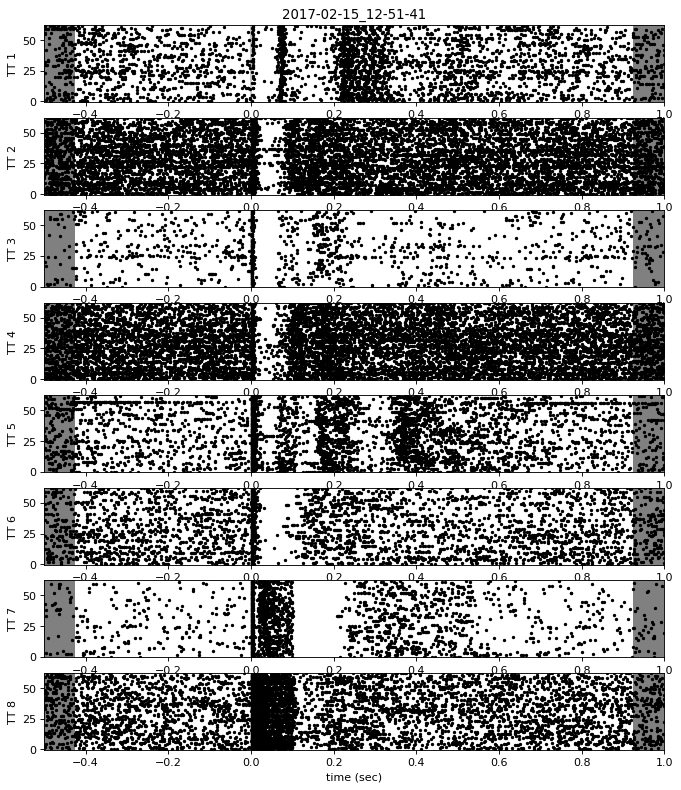

In [23]:
#This line makes the figure larger, similar to the size we would view it during recording.
#To make the function draw on this figure object, instead of create a new one, use replace=1.
fig=plt.figure(figsize=(10, 12), dpi= 80, facecolor='w', edgecolor='k')

#Referring to session by index. You can also refer by timestamp, see below.
#The list of sessions is [laserpulse, am tuning]. So the laserpulse is index 0 or index -2 (either works).
ei.plot_array_raster(session=0, replace=1) 

There are a lot of interesting responses to the laser. We already know that there is a cool cell on Tetrode 8 (we selected this dataset because of the cell), so let's zero in on Tetrode 8. We can do this with the `plot_session_raster()` method. This method plots a single tetrode at a time, so you have to supply the tetrode number to plot. Otherwise it works the same as `plot_array_raster()`.

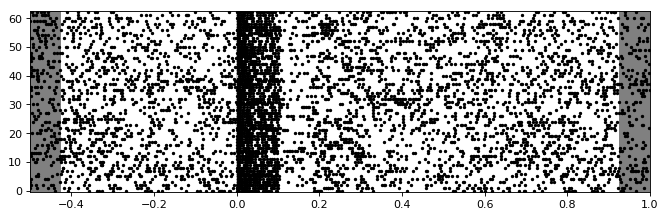

In [5]:
fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')

ei.plot_session_raster(0, tetrode=8, replace=1)

## Sorting raster plots

Raster plots, by default, organize the trials on the Y axis sequentially. However, if you presented AM sounds at a number of different AM rates, it can be much more useful to sort the trials so that the trials where a specific AM rate were presented are all grouped together. The methods `plot_session_raster()` and `plot_array_raster` automatically try to sort the trials according to a behavior variable called `currentFreq`. If behavior was collected for a recording session, and if this variable is saved in the behavior file, the trials will be grouped together. Current tuning curve paradigms use this variable name to store the frequency of the sound on each trial, but you may need to tell the methods to use a different variable name depending on your paradigm and what you want to sort by. 

### Plotting responses to AM, sorted by AM rate
To illustrate sorting trials, we will plot an event-locked raster for Tetrode 8 during the AM tuning session, with trials sorted by the AM rate.

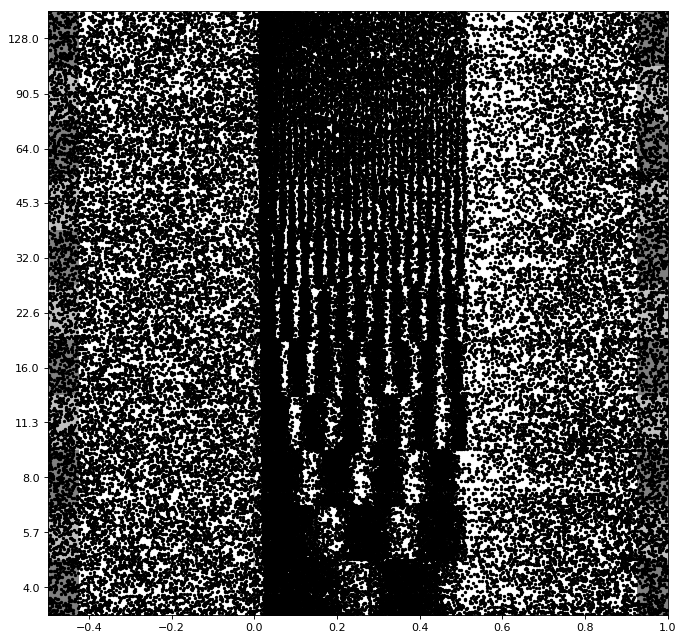

In [35]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

ei.plot_session_raster(1, tetrode=8, replace=1, sortArray='currentFreq') 
#'currentFreq' is the default, so you don't really need the last argument. Only here for clarity

## Are there single clusters with both laser response and AM response? 

The goal of this recording was to find clusters with laser responses, and then determine how they respond to AM sounds. So far, we have been plotting rasters of **all** the spiking activity recorded on a tetrode. Each point may come from different clusters, from background activity that cannot be attributed to one unit, or even from electrical noise picked up from the speaker or other sources. Often, we want to verify that there are really single clusters that have the responses we want before we continue to spend time recording at this site.

### The `cluster_color_psth()` method
This method provides the most convenient way to view the response of individual clusters across multiple recording sessions. The only required argument is a list of session indices, although the `plotType` argument provides a way to plot tuning curves for particular sessions instead of the default PSTHs.

In [36]:
help(ei.cluster_color_psth)

Help on method cluster_color_psth in module jaratoolbox.ephysinterface:

cluster_color_psth(self, sessionList, plotType=None, site=-1, experiment=-1, tuningTimeRange=[0.0, 0.1]) method of jaratoolbox.ephysinterface.EphysInterface instance
    Display cluster waveforms and a PSTH or tuning curve for each cluster.
    Performs multisession clustering for each tetrode recorded at the site.
    Args:
        sessionList (list of indices): The indices of the sessions to be included in the multisession clustering.
        plotType (list of str): A list the same length as sessionList, containing the type of plot for that session.
                                Current valid plotTypes are: 'psth', 'tuning'
        site (index): The index of the site to pull sessions from.
        experiment (index): The index of the experiment to get the site from.
        tuningTimeRange (list of float): List containing [start, stop] times relative to event onset over which to
                               

Writing .clu.1 file for session 2017-02-15_12-51-41
Writing .clu.1 file for session 2017-02-15_13-21-56
Saving tetrode stats to /home/nick/data/testdata/ephys/pinp015/online_multisession_2017-02-15_12-51-41-2017-02-15_13-21-56/Tetrode1_stats.npz
Writing .clu.1 file for session 2017-02-15_12-51-41
Writing .clu.1 file for session 2017-02-15_13-21-56
Saving tetrode stats to /home/nick/data/testdata/ephys/pinp015/online_multisession_2017-02-15_12-51-41-2017-02-15_13-21-56/Tetrode2_stats.npz
Writing .clu.1 file for session 2017-02-15_12-51-41
Writing .clu.1 file for session 2017-02-15_13-21-56
Saving tetrode stats to /home/nick/data/testdata/ephys/pinp015/online_multisession_2017-02-15_12-51-41-2017-02-15_13-21-56/Tetrode3_stats.npz
Writing .clu.1 file for session 2017-02-15_12-51-41
Writing .clu.1 file for session 2017-02-15_13-21-56
Saving tetrode stats to /home/nick/data/testdata/ephys/pinp015/online_multisession_2017-02-15_12-51-41-2017-02-15_13-21-56/Tetrode4_stats.npz
Writing .clu.1 f

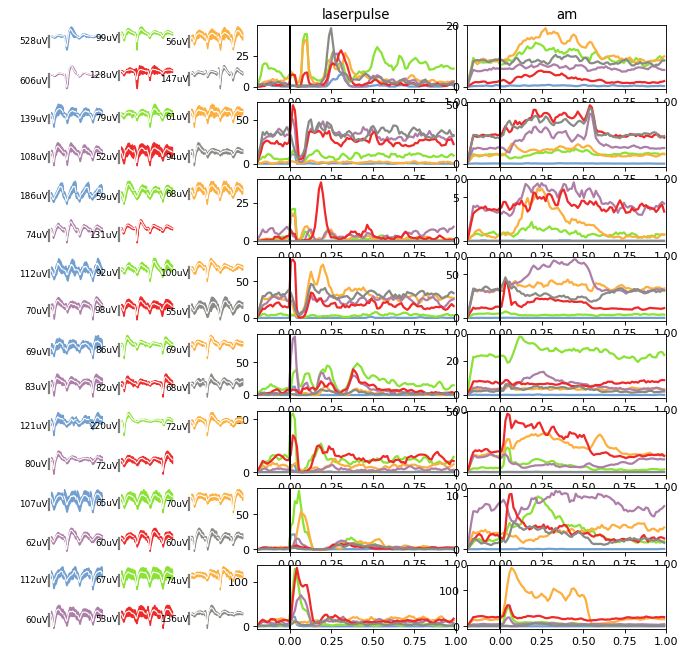

In [8]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

ei.cluster_color_psth(sessionList=[-2, -1])

## Alternative syntax for selecting experiments, sites, and sessions
In addition to specifying sessions, sites, and experiments using indices (since all are stored in lists in order of their collection), you can use: 
* Timestamps (**12-51-41**) to specify a session
* Depth (**2902**) to specify a site **TODO: We need to implement this, it doesn't work yet**
* Date (**2017-02-15**) to specify an experiment **TODO: We need to implement this, it doesn't work yet**

In [46]:
ei.get_session_obj(session=-1, experiment=-1, site=-1).sessiontype #Typical way to select

'am'

In [47]:
ei.get_session_obj(session='13-21-56', experiment=-1, site=-1).sessiontype #Using timestamp for session

'am'

## Extending ephysinterface

The EphysInterface object is commonly extended with new plotting methods that serve a desired purpose for a particular experiment. When possible, we should follow a set of conventions for extending the object for more efficient code reuse. 

1. If you have vastly different data loading needs, consider subclassing EphysInterface and redefining the load_session_data method. See the section on **Loading alternate data formats**
1. Conform as closely to the arguments of other functions as possible. If all functions require a session (or list of sessions), an experiment, a site, some tetrodes to plot, have an option to limit to a specific cluster, and have a replace/newfig option, then it will be a lot easier for someone to learn and remember how to use the functions. 
1. Rely as much as possible on plotting code that already exists. There are top level `plot_raster()` and `plot_psth()` functions in this module, which both do some pre-processing before calling `extraplots` functions to do the actual plotting. 
1. Use `load_session_data()` to get data. This function then calls `get_session_obj()` which allows users to specify sessions with timestamps, sites with depths, and experiments with dates instead of just using indices if they want. This is likely to be an important feature for new users learning the system, who are less comfortable with thinking about plotting the -2 session from the -1 site.

## Loading alternate data formats

Note: This is a work in progress and probably confusing. The first time someone tries to load an alternate data format this will probably have to be improved with the knowledge from that process. 

### Native data format
`ephysinterface` is designed to work with ephys data saved using the 2014 version of the OpenEphys GUI. In this format, a new folder is created for each recording session (given a timestamp with DD-MM-YYYY_HH-MM-SS). Inside, there are:
* **events** stored as *all_channels.events*
* **spike timestamps** stored as *TetrodeX.spikes* (One for each tetrode)
* **continuous data** stored as *CHXXX.continuous* (One for each cont. channel you are saving)
We don't work with the newer versions of OpenEphys that store data in new formats (like HDF5).

Addionally, the system is designed to work with behavior data saved out by *taskontrol* paradigms (https://github.com/sjara/taskontrol). 

Loading alternate data formats will most likely be accomplished by subclassing `EphysInterface` and redefining the `load_session_data()` method. These are design decisions regarding how that method works, which affects the data structures that your redefined method will need to return in order to be compatible with the rest of the methods. The method returns both the ephys and behavior data if both exist. Otherwise, it returns the ephys data and `None` for the behavior data.  

### Ephys data
We chose to load ephys data using a function (`jaratoolbox.ephyscore.load_ephys()`). If the lab switched formats, and you need to change everything, it is probably worthwile to just make this function work with the new format. If you are not in the Jaramillo lab, and you need to make a function to load your data, you can emulate the beahvior of this function, which does the following: 
1. Read the raw openephys .spikes file
1. Convert timestamps to seconds (based on sampling rate)
1. Convert waveform amplitudes to uV (based on bit depth and gain used during recording)
1. **Important**: The method has an optional parameter `cluster`. If left as `None` (the default) then all spiketimes and samples from the tetrode are returned. If you pass an integer value instead, then the function will load the cluster data and return only the spiketimes and samples that come from that cluster.
1. Re-package event timestamps into a dictionary according to event type (defined per paradigm) and onset/offset. 
1. Return a dictionary called ephysData containing the spike timestamps, waveforms, and the dictionary of event times. 

Ideally, your method would load your ephys data, convert to seconds/uV based on your recording parameters and file format, and then return the same `ephysData` dictionary. There is no need to rely on the `jaratoolbox.ephyscore` module for your ephys data loading. We just do that so that we have a common way to load ephys data that can be reused by any code in the lab.


### Behavior data
We then load the behavior data using one of the loading classes in `jaratoolbox.loadbehavior`. The `BehaviorData` class is used unless the user specifies otherwise. These loading classes are `dict` subclasses that construct themselves. Basically, they are a dictionary of arrays of length *nTrials*. Examples of some of the keys are: **currentFreq** (what was the sound frequency presented on this trial?), and **valid** (was this a valid trial?) If you store your behavior data in some different way (which you would, unless you are using *taskontrol* for behavior or stimulus presentation), then your `load_session_data()` method can load your format and return a dictionary containing the per-trial values of whatever parameter you care about. We really only care about per-trial values of things like stimulus frequency or intensity, so that we can sort rasters and make tuning curves. 

